In [1]:
%matplotlib inline

from IPython.display import clear_output
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import cv2 as cv
import threading

1325 images found
1325 masks found
img name: /Users/heathsmith/datasets/MaSTr1325_images_512x384/0001.jpg max: 255 min: 53 dims: (384, 512, 3)
img name: /Users/heathsmith/datasets/MaSTr1325_masks_512x384/0001m.png max: 3 min: 0, dims: (384, 512)


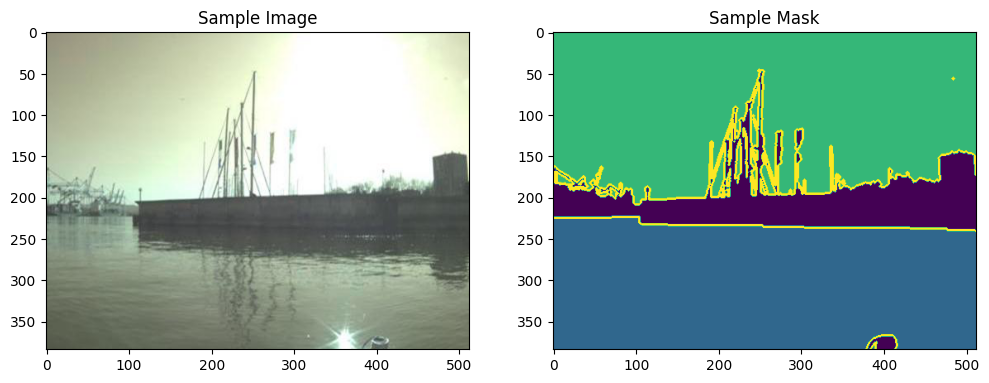

In [18]:
img_path = Path(r'/Users/heathsmith/datasets/MaSTr1325_images_512x384')
msk_path = Path(r'/Users/heathsmith/datasets/MaSTr1325_masks_512x384')

images = [os.path.join(img_path, p) for p in os.listdir(img_path)]
masks = [os.path.join(msk_path, p) for p in os.listdir(msk_path)]

images = sorted(images)
masks = sorted(masks)

print(f"{len(images)} images found")
print(f"{len(masks)} masks found")

sample = cv.imread(images[0], -1)
msk_sample = cv.imread(masks[0], -1)
msk_sample[msk_sample > 2] = 3

print(f"img name: {images[0]} max: {np.max(sample)} min: {np.min(sample)} dims: {sample.shape}")
print(f"img name: {masks[0]} max: {np.max(msk_sample)} min: {np.min(msk_sample)}, dims: {msk_sample.shape}")

fig = plt.figure(figsize=(12, 12))

ax = plt.subplot(1, 2, 1)
plt.title("Sample Image")
plt.imshow(sample)

ax1 = plt.subplot(1, 2, 2)
plt.title("Sample Mask")
plt.imshow(msk_sample, vmin=0.0, vmax=3.0)

plt.show()

In [19]:
def shuffle_dataset(ds, shuffled_idx, shuffled_ds):
    """"""
    # shuffle the dataset
    ds = np.asarray(ds)
    shuffled_ds[:] = ds[shuffled_idx]

# create a data processing pipeline function
def data_pipeline(images, labels, batch_size=None, seed=123):
    """ Process the dataset """
    print('-'*80)

    np.random.seed(seed)

    images = [cv.imread(img, -1) for img in images]
    labels = [cv.imread(lbl, -1) for lbl in labels]

    # scale images between 0-1
    print("Scaling images..")
    images = list(map(lambda x: x / 255.0, images))


    # replace all 4's with 3's
    print("Filtering masks..")
    labels = np.asarray(labels)
    labels[labels > 2] = 3

    # resize the images
    print("Resizing images..")
    images = list(map(lambda x: (cv.resize(x, (384, 384))), images))
    labels = list(map(lambda x: (cv.resize(x, (384, 384))), labels))

    # expand images to have dimension (H x W x D)
    print("Setting mask dimensions..")
    labels = list(map(lambda x: np.expand_dims(x, axis=2), labels))

    print("Shuffling dataset..")
    shuffled_idx = np.random.permutation(len(images))
    shuffled_imgs, shuffled_lbls = list(), list()
    t1 = threading.Thread(target=shuffle_dataset, args=(images, shuffled_idx, shuffled_imgs))
    t2 = threading.Thread(target=shuffle_dataset, args=(labels, shuffled_idx, shuffled_lbls))
    for thread in (t1, t2):
        thread.start()
    for thread in (t1, t2):
        thread.join()

    images, labels = np.asarray(shuffled_imgs), np.asarray(shuffled_lbls)

    if batch_size is not None:
        n_batches = np.shape(images)[0] // batch_size
        print(f"Generating {n_batches} batches.")
        batched_images, batched_labels = [], []
        a = 0
        b = batch_size
        for i in range(0, n_batches):
            batched_images.append(np.asarray(images[a:b]))
            batched_labels.append(np.asarray(labels[a:b]))
            a += batch_size
            b += batch_size
        images, labels = np.asarray(batched_images), np.asarray(batched_labels)

    print("x data: ")
    print(images.shape, images[0].shape, images.dtype, type(images))
    print("y data : ")
    print(labels.shape, labels[0].shape, labels.dtype, type(labels))

    print('-'*80)
    # return the dataset object
    return images, labels

# process the datasets
images, masks = data_pipeline(images, masks)


--------------------------------------------------------------------------------
Scaling images..
Filtering masks..
Resizing images..
Setting mask dimensions..
Shuffling dataset..
x data: 
(1325, 384, 384, 3) (384, 384, 3) float64 <class 'numpy.ndarray'>
y data : 
(1325, 384, 384, 1) (384, 384, 1) uint8 <class 'numpy.ndarray'>
--------------------------------------------------------------------------------


In [20]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=123):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [21]:
x_train, y_train = images[:1060], masks[:1060]
x_val, y_val = images[1061:], masks[1061:]

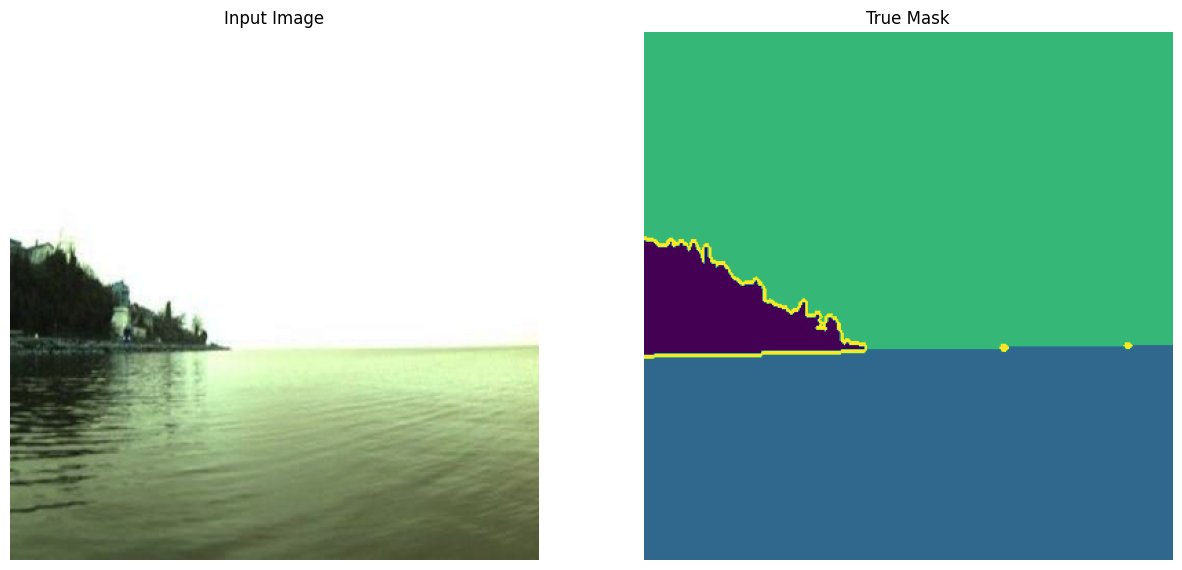

In [22]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

sample_image, sample_mask = x_train[0], y_train[0]
display([sample_image, sample_mask])

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[384, 384, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [24]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[384, 384, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [25]:
OUTPUT_CLASSES = 4

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

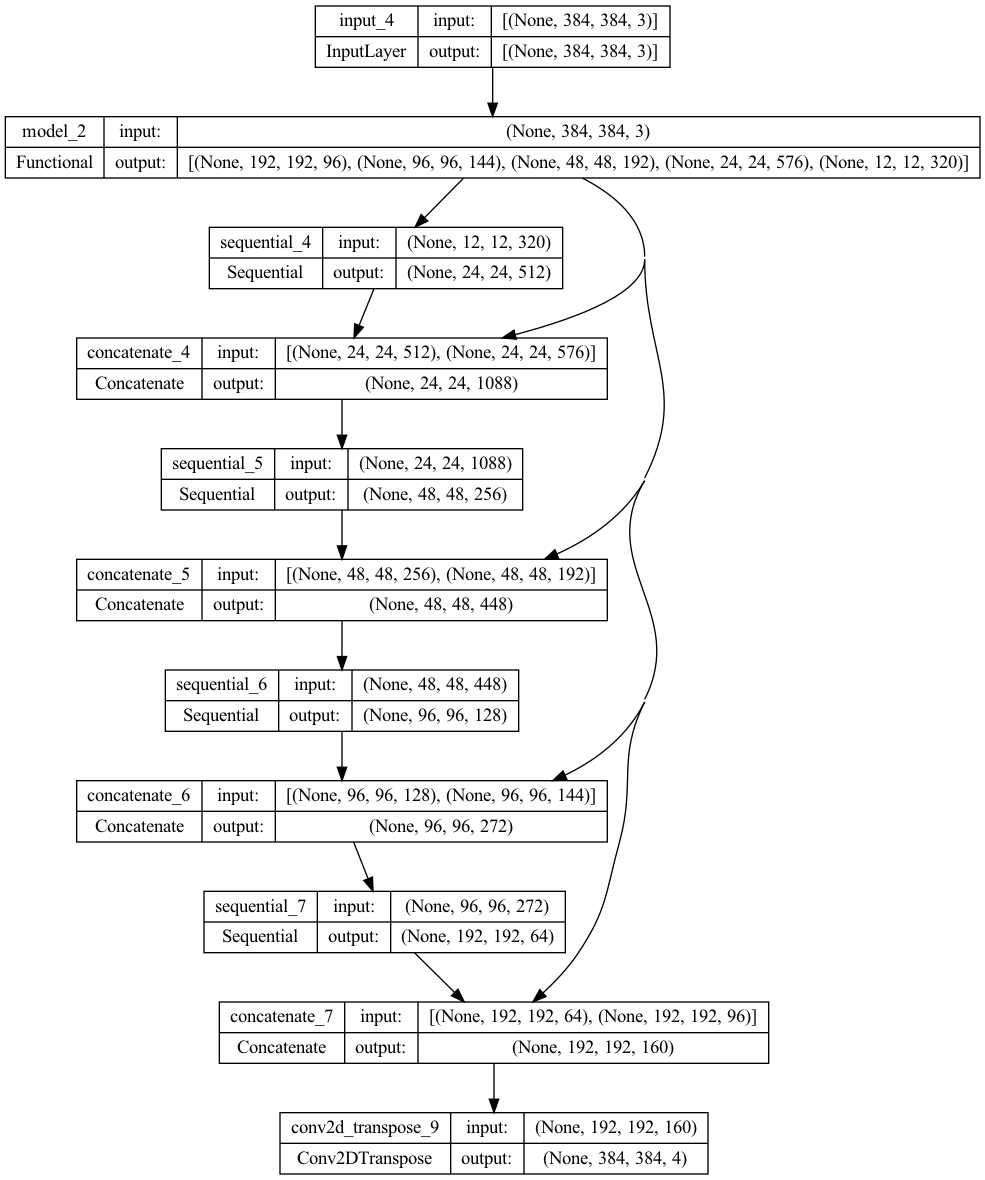

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        [(None, 192, 192, 96),       1841984   ['input_4[0][0]']             
                              (None, 96, 96, 144),                                                
                              (None, 48, 48, 192),                                                
                              (None, 24, 24, 576),                                                
                              (None, 12, 12, 320)]                                                
                                                                                            

1/1 [==============================] - 0s 50ms/step
pred mask shape: (384, 384, 1) min: 0 max: 3
Test image Shape: (1, 384, 384, 3)


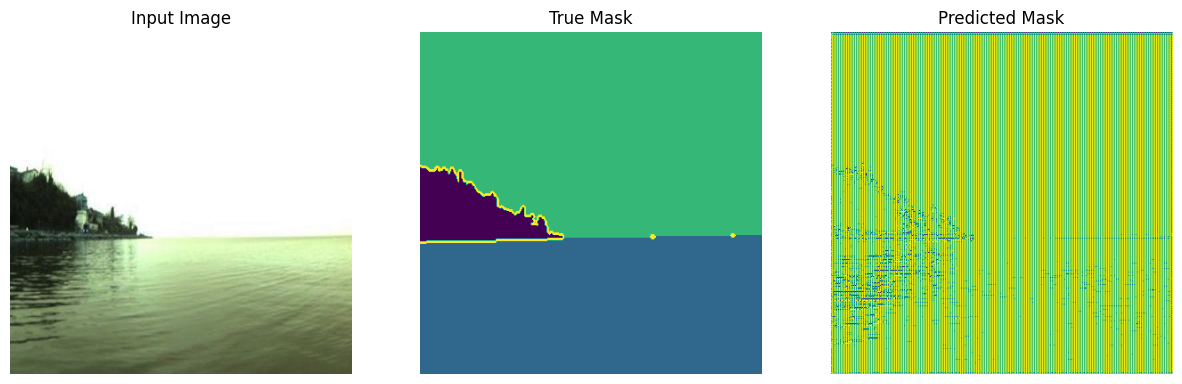

In [29]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  print(f"pred mask shape: {np.shape(pred_mask[0])} min: {np.min(pred_mask[0])} max: {np.max(pred_mask[0])}")
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    test_img = sample_image[tf.newaxis, ...]
    pred = model.predict(test_img)
    get_mask = create_mask(pred)
    print(f"Test image Shape: {np.shape(test_img)}")
    display([sample_image, sample_mask, get_mask])

show_predictions()

In [30]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 52ms/step
pred mask shape: (384, 384, 1) min: 0 max: 3
Test image Shape: (1, 384, 384, 3)


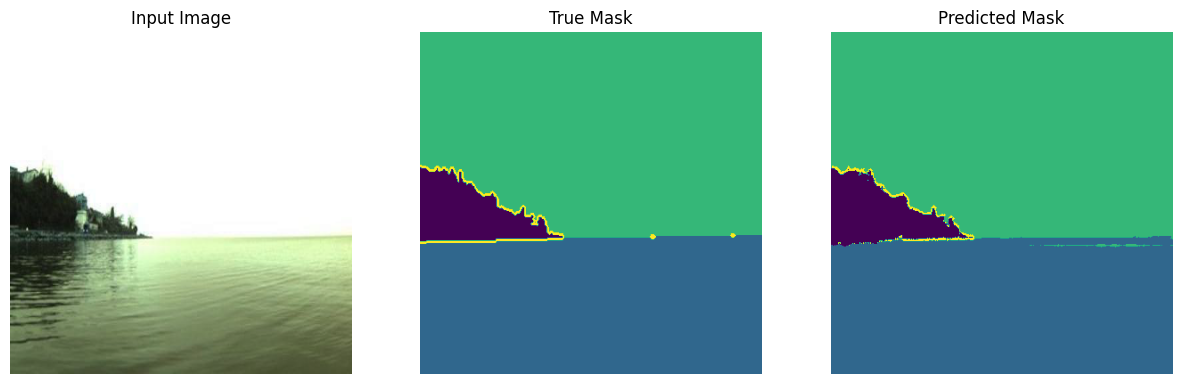


Sample Prediction after epoch 10

17/17 [==============================] - 83s 5s/step - loss: 0.0443 - accuracy: 0.9841 - val_loss: 0.0566 - val_accuracy: 0.9806


In [33]:
EPOCHS = 10
model_history = model.fit(x_train, y_train, epochs=EPOCHS,
                          validation_data=(x_val, y_val),
                          batch_size=64,
                          callbacks=[DisplayCallback()])